In [ ]:
pip install uv && uv pip install --system -r https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/requirements.txt

Using Python 3.12.12 environment at: /usr
Audited 11 packages in 415ms


In [ ]:
import os
import urllib.request # This module lets Python download data from the internet.

if not os.path.exists("theverdict.txt"):  # to check if theverdict.txt folder already exists so that we do not download it again
  url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/refs/heads/main/ch02/01_main-chapter-code/the-verdict.txt")

  file_path = "theverdict.txt" # This is the name you want to save the file as after downloading.
  urllib.request.urlretrieve(url,file_path)  # This line downloads the file from the URL and saves it locally as theverdict.txt.

In [ ]:
# let's open the file in python as it is just sitting in our computer for now

with open("theverdict.txt", "r", encoding = "utf-8") as f :
  raw_text = f.read()

print(len(raw_text)) # 20479 for this, make sure you are not missing any chars/words

20479


In [ ]:
import re
text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)
print(result, len(result)) # this splits with whitespaces

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.'] 11


In [ ]:
#  Let’s modify the regular expression splits on whitespaces (\s), commas, and periods ([,.])
result = re.split(r'([,.]|\s)', text)
print(result, len(result))

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', ''] 19


In [ ]:
# Removing whitespaces
result = [item for item in result if item.strip()]
print(result, len(result))

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.'] 10


**Note**

 When developing a simple tokenizer, whether we should encode
 whitespaces as separate characters or just remove them depends on our appli
cation and its requirements. Removing whitespaces reduces the memory and
 computing requirements. However, keeping whitespaces can be useful if we
 train models that are sensitive to the exact structure of the text (for example,
 Python code, which is sensitive to indentation and spacing). Here, we remove
 whitespaces for simplicity and brevity of the tokenized outputs. Later, we will
 switch to a tokenization scheme that includes whitespaces

In [ ]:
# Handling more punctuations
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [ ]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))

4690


In [ ]:
print(preprocessed[:30])


['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


##Converting into Token IDs

What we are going to do is since we are building a model from scratch, we are going to tokenize the text first ( we have already done this ) and build a vocabulary. Each unique token is
 added to the vocabulary
 in alphabetical order.

In [ ]:
all_words = sorted(set(preprocessed)) # set to remove duplciates and sort to order alphabetically
# then assign a unique integer id
vocabulary = {}
a = len(all_words)
while a > 0:
  i = 0
  for word in all_words:
    vocabulary[word] = i
    i = i + 1
    a = a-1

print(list(vocabulary.items())[:3])

[('!', 0), ('"', 1), ("'", 2)]


In [ ]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
      break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


In [ ]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


## Adding special context tokens

Now, we are going to extend this vocabulary with special tokens.

For example, depending on the tokenizer,
we add an <|unk|> token to represent new and unknown words that were not part of the training
data and thus not part of the existing vocabulary. Furthermore, we add an <|endoftext|>
token that we can use to separate two unrelated text sources.


More of these special tokens are

[BOS] (beginning of sequence) marks the beginning of text


[EOS] (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)


[PAD] (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)

In [ ]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>","<|unk|>"])
vocab = { token:integer for integer,token in enumerate(all_tokens)}
len(vocab.items())

1132

In [ ]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [ ]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [ ]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [ ]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## Byte Pair Encoding

**Goal:** Split text into subword units to handle rare words efficiently.

**Steps:**
1. Split words into **characters** → each char is a symbol.
   - e.g. "eating" → e a t i n g
2. Count **all adjacent symbol pairs** in the dataset.
3. Merge the **most frequent pair** into a new token.
   - e.g. (i, n) → "in"
4. Add the new token to the vocabulary. **Original chars usually stay**.
5. Repeat steps 2-4 until desired vocab size or merges reached.
6. Encode text using the merged subwords; decode by reversing the process.

**Key Points:**
- Vocabulary grows with **subwords**, not just single characters.
- Frequent sequences get their **own token**, rare sequences stay split.
- Original characters remain unless fully merged.
- Helps LLMs handle unknown or rare words efficiently.


In [ ]:
pip install tiktoken

In [ ]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


In [ ]:
tokenizer = tiktoken.get_encoding("gpt2") # this loads the tokenzier used by gpt2 i.e. BPE

text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"}) #token ids

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [ ]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


##Data sampling with a sliding window

We want LLMs to generate one word at a time, so we want to prepare the training data in such a way that we have got an input and a target. Target is the next word in a sequence that the LLM has to predict. The LLM can't access words past the target.

In [ ]:
with open("theverdict.txt", "r", encoding = "utf-8") as f:
  raw_text = f.read()

# passing in the raw text to bpe

enc_text = tokenizer.encode(raw_text)
enc_text[:10], tokenizer.decode(enc_text[:10])

([40, 367, 2885, 1464, 1807, 3619, 402, 271, 10899, 2138],
 'I HAD always thought Jack Gisburn rather')

For each text chunk (tokens), we want the inputs and targets.


Since we want the model to predict the next word/token, the targets are the inputs shifted by one position to the right

In [ ]:
enc_sample = enc_text[50:]

In [ ]:
context_size = 5
input = enc_sample[:context_size]
target = enc_sample[1:context_size + 1]
print(f"Input :{input}")
print(f"Target: {target}")

Input :[290, 4920, 2241, 287, 257]
Target: [4920, 2241, 287, 257, 4489]


In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257
[290, 4920, 2241, 287, 257] ----> 4489


In [ ]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a
 and established himself in a ---->  vill


In [ ]:
# LLMs predict tokens not text, let's see an example.

text = "ghkdjhh ghjkjfe over home jnj"
example_enc = tokenizer.encode(text)
len(example_enc)

13

In [ ]:
for i in range(1, context_size+1):
    context = example_enc[:i]
    desired = example_enc[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

gh ----> k
ghk ----> dj
ghkdj ----> hh
ghkdjhh ---->  gh
ghkdjhh gh ----> j


###Let's starting working with PyTorch and implement a DataLoader that iterates over the input dataset and returns the inputs and targets shifted by one as a PyTorch Tensor.

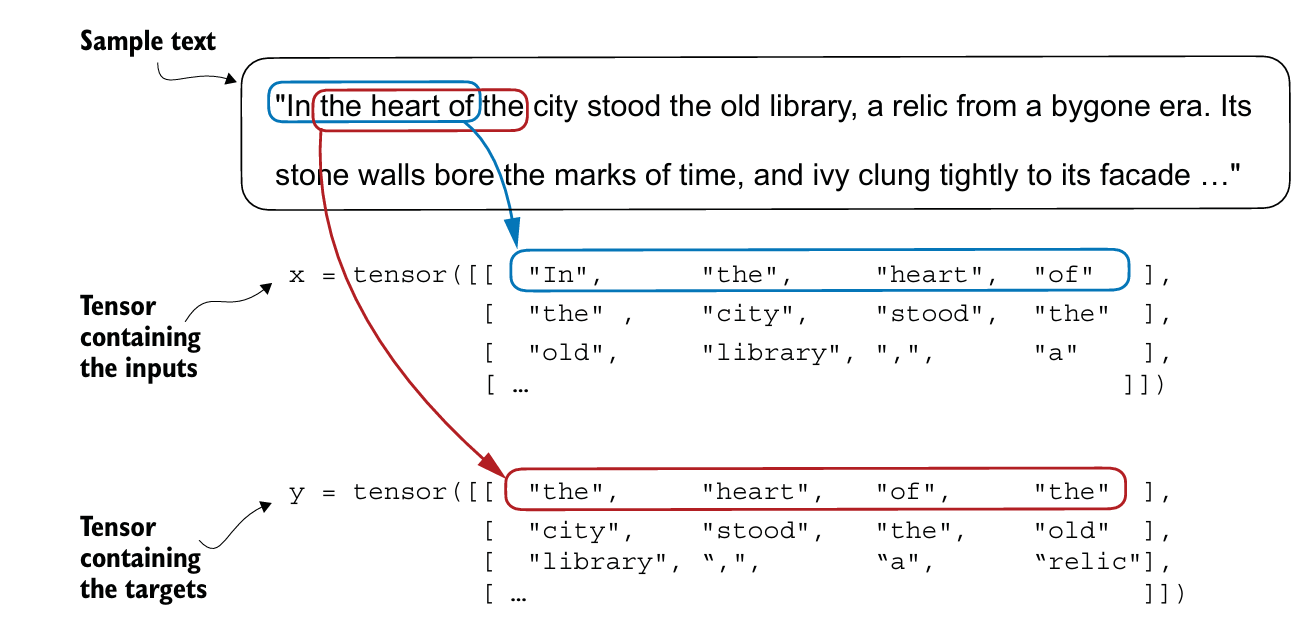

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device : {device}")

Using device : cpu


##Use of max_length and stride (10,5 in the example below)

Step 1 (first sequence):

Input: tokens [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Target: tokens [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Step 2 (second sequence, stride 5):

Input: tokens [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Target: tokens [7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

Step 3:

Input: [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Target: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

…and so on until the end of the token list.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, max_length, stride):
  # max_length is how many token_ids the model sees at once
  # if we set max_length as 10, it sees the first 10 token in the first step
  # and those first 10 are stored as a single row in the input_ids list
  # it's the same for target as well.
  # and stride is how much we will slide over in the next iteration of the sequence
    self.input_ids = []
    self.target_ids = []

    token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
    assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"


  # Use a sliding window to chunk the book into overlapping sequences of max_length
    for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
        return len(self.input_ids)

  def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

## What does this exactly do?

It turns a long text into many small overlapping training sequences that a GPT model can learn from.

It creates:

input_ids → the tokens the model sees

target_ids → the tokens the model must predict next

Each pair is one training sample.


When we use it in the dataloader later, it returns one sample at once and the dataloader stacks the sample one by one.

###Note : A sequence refers to one row in the input_ids/ target_ids.

In [ ]:
def create_dataloader_v1(txt, batch_size, max_length,
                         stride, shuffle, drop_last,
                         num_workers):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride) # this will store the single samples individually as a tuple
    # (input, target)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

The DataLoader will return smth like this :  

Batch 0:

input_batch = [[1,2,3,4,5], [4,5,6,7,8]]


target_batch = [[2,3,4,5,6], [5,6,7,8,9]]


Batch 1:

input_batch = [[7,8,9,10,11], [10,11,12,13,14]]


target_batch = [[8,9,10,11,12], [11,12,13,14,15]]


In [ ]:
dataloader = create_dataloader_v1(txt = raw_text, batch_size=1, max_length=4,
                         stride=1, shuffle=True, drop_last=False,
                         num_workers=0)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[33954,   271,  3973,  9899]])

Targets:
 tensor([[  271,  3973,  9899, 14678]])


###We looked at the result of one batch returned by DataLoader and confirmed that it is working.



##Creating Token Embeddings

Lastly let us embed the tokens in a continuous vector representation using an embedding layer.
Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

In [ ]:
# Let's say that these are our input_ids for our input text.
input_ids = torch.tensor([2,3,4,5])

# let's keep our vocab size = 6 and the embedding dimension = 3
vocab_size = 6
emb_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, emb_dim)
embedding_layer
# the output is 6, 3 meaning for all 6 tokens in our vocab, we have a 3 dim embedding representing ti

Embedding(6, 3)

nn.Embedding is basically a lookup table containing Input ( token IDs in integers ) and corresponding output for that ID which is a dense vector which we call embeddings.

It creates a matrix of random numbers ( PyTorch initializes it automatically ) with the shape ( vocab_size, d_model) .

The embedding matrix is shared across the entire model and keeps getting refined after every update. Words ( or tokens) that appear in many contexts get more accurate embeddings over time.

Token -> Token IDs -> Embedding Table for those IDs (not the words to be exact)

In [ ]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


## Positional Encoding

The models knows what tokens are present but semantically.

So we need to add positional embeddings. The reason we do this is because transformers process all tokens in parallel, not one by one like RNNs.

So, we need to explicitly give them positional information. So, we have another matrix - Positonal Embedding Matrix.

Its shape is ( max_sequence_length, d_model).

So, for each token we add the positional embedding vector to its token embedding vector elementwise. Positional Embeddings are reused throughout the model and are not tunable parameters meaning it is only calculated once and fixed.

In [ ]:
# Creating an embedding matrix for our actual data

vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [ ]:
 max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False, drop_last = False, num_workers = 0
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print(inputs, inputs.shape)

tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]]) torch.Size([8, 4])


In [ ]:
token_embedding = token_embedding_layer(inputs)
token_embedding[0].shape

torch.Size([4, 256])

In [ ]:
#GPT-2 uses absolute position embeddings, so we just create another embedding layer
#Generating a positional embedding matrix for context-size of the LLM

context_length = max_length
pos_embedding_layer = torch.nn.Embedding(max_length,output_dim)
pos_embedding_layer

Embedding(4, 256)

In [ ]:
pos_embedding = pos_embedding_layer(torch.arange(max_length))
pos_embedding.shape

torch.Size([4, 256])

In [ ]:
input_embeddings = token_embedding + pos_embedding
print(input_embeddings.shape)

torch.Size([8, 4, 256])
